# Kalman's Filter

### ESTIMACION DE LA TRAYECTORIA DE UN VEHÍCULO

#### Introducción

<p style='text-align: justify;'>
Se desea estimar la trayectoria de un vehículo, es decir la posición, velocidad y aceleración del mismo. Se cuenta con los datos reales de un vehículo, en los archivos .dat. Estos son los datos contra los cuales se comparará la estimación que obtengan al aplicar el FK. Lo primero que hay que hacer es generar las mediciones que serían la entrada al filtro de
Kalman, estas mediciones se debeán generar de la siguiente manera:
    
Desde el ítem 1 al 3 se supone que se mide en forma periódica (1seg) los siguientes datos.
</p>

- Se mide la posición afectada por ruido blanco (gaussiano) de 10m de desvío estándar. Es decir que se le debe agregar ruido blanco con una distribución gaussiana con media cero y desvío 10.

- Se mide la posición afectada por ruido blanco (uniforme) de 10m de desvío estándar. Similar al ítem anterior. La idea es comparar con el ítem anterior. Analizar si hubo algún cambio.

- Se mide la posición y la velocidad afectadas por ruido blanco (gaussiano) de 10m y 0.2m/s de desvíos respectivamente. Analizar si mejora la estimación.

<p style='text-align: justify;'>
NOTA: Hay que tener en cuenta que al inicializar el Kalman en general no se conoce exactamente cuál es la posición, velocidad y aceleración del vehículo sino que tienen una aproximación de estas con cierto error. Se tomará como condiciones
iniciales:
</p>

<p style='text-align: center;'>
    $\hat x_{0/0} = [10.7533, 36.6777, −45.1769, 1.1009, −17.0, 35.7418, −5.7247, 3.4268, 5.2774]^{T} \in R ^{9}$
</p>

<p style='text-align: center;'>
    $P_{0/0} = \begin{bmatrix} 100 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 100 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 100 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0.01 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.01 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.01 \end{bmatrix} \in R ^{9x9}$
</p>

<p style='text-align: justify;'>
Considere $Q = 0.3 I^{9×9}$ y obtenga R seg´un los datos de mediciones que corresponda
</p>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def estimacionesXP(X, P, A, Q):
    """Estimaciones de Xn y Pn con la informacion hasta n-1"""
    X = np.dot(A, X.T)
    P = np.dot(A, np.dot(P, A.T)) + Q 
    return(X.T, P)

In [3]:
def Filtro_Kalman(X, P, Y, C, R):
    """Estimaciones de Xn y Pn con la informacion hasta n y calculo de
    la ganancia de Kalman Kn"""
    k1 = R + np.dot(C, np.dot(P, C.T)) 
    K = np.dot(P, np.dot(C.T, (k1.I)))
    Xnn = X.T + np.dot(K, (Y.T - np.dot(C, X.T)))
    Pnn = np.dot(np.identity(9) - np.dot(K, C), P)
    return (Xnn.T, Pnn, K) 

In [4]:
N = 1000

In [5]:
#   LECTURA DE DATOS 

posicion = np.loadtxt('posicion.dat')
velocidad = np.loadtxt('velocidad.dat')
aceleracion = np.loadtxt('aceleracion.dat')

In [6]:
#   TIEMPO DE MUESTREO

tk = 1 #segundos

In [7]:
#   DEFINICION DE Xn 

xn = np.zeros((posicion.shape[0], (posicion.shape[1] - 1) * 3))

for col in range(xn.shape[1]):
    if col < (posicion.shape[1] - 1):
        for row in range(xn.shape[0]):
            xn[row, col] = posicion[row, col + 1]
    elif col < (posicion.shape[1] + velocidad.shape[1] - 2):
        for row in range(xn.shape[0]):
            xn[row, col] = velocidad[row,col - 2]
    elif col < (posicion.shape[1] + velocidad.shape[1] + aceleracion.shape[1] - 3):
        for row in range(xn.shape[0]):
            xn[row, col] = aceleracion[row,col - 5]

In [8]:
#   DEFINICION DE MATRICES DE ESTADO

A = np.matrix([[1, 0, 0, tk, 0, 0, (tk**2)/2, 0, 0],
              [0, 1, 0, 0, tk, 0, 0, (tk**2)/2, 0],
              [0, 0, 1, 0, 0, tk, 0, 0, (tk**2)/2],
              [0, 0, 0, 1, 0, 0, tk, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, tk, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, tk],
              [0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1]])

C = np.matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [9]:
#   RUIDO DE PROCESO
Q = 0.3*np.identity(9)

#   RUIDO DE MEDICION
R = np.matrix([[100, 0, 0],
               [0, 100, 0],
               [0, 0, 100]])

In [10]:
xn_n = np.matrix(np.zeros((351, 9)))
yn = np.matrix(np.zeros((351, 3)))

<p style='text-align: justify;'>
    Se mide la posición afectada por ruido blanco (gaussiano) de media cero y 10m de desvío estándar.
</p>

In [11]:
for i in range(N):
    #   RUIDO DE MEDICION
    #   Se utiliza un ruido con distribucion gaussiana
    nu_gauss = np.zeros((posicion.shape[0], (posicion.shape[1] - 1)))
    
    for col in range(posicion.shape[1] - 1):
        nu_gauss[:,col] = np.random.normal(0, 10, posicion.shape[0])

    # media = nu_gauss.mean(0)
    # varianza = nu_gauss.var(0)
    
    #   Defino Yn como la suma del las variables medidas mas un ruido de medicion
    
    yn_i = np.dot(xn, C.T) + nu_gauss
    
    #   Xn|n
    xn_n_i = np.matrix(np.zeros((351, 9)))
    
    xn_n_i[0,:] = [10.7533, 36.6777, -45.1769,
                   1.1009, -17.0, 35.7418,
                   -5.7247, 3.4268, 5.2774]
    
    #   Pn|n
    pn_n = np.matrix([[100, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 100, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 100, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0.01, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0.01, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0.01]])
    
    # Xn|n-1
    xn_n1 = np.matrix(np.zeros((351,9)))
    
    
    for i in range(351):
        (xn_n1[i,:], pn_n1) = estimacionesXP(xn_n_i[i,:], 
                                             pn_n, 
                                             A, 
                                             Q)
        if i < 350:
            (xn_n_i[i+1,:], pn_n, Kn) = Filtro_Kalman(xn_n1[i,:], 
                                                      pn_n1, 
                                                      yn_i[i,:], 
                                                      C, 
                                                      R)
            
    xn_n = xn_n + xn_n_i
    yn = yn + yn_i

In [12]:
xn_n = xn_n / N
yn = yn / N

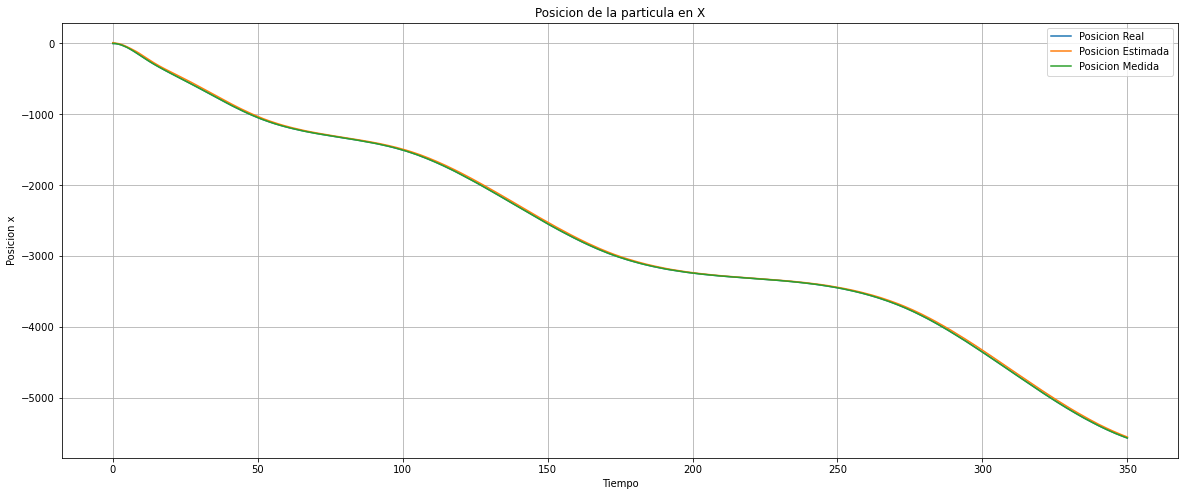

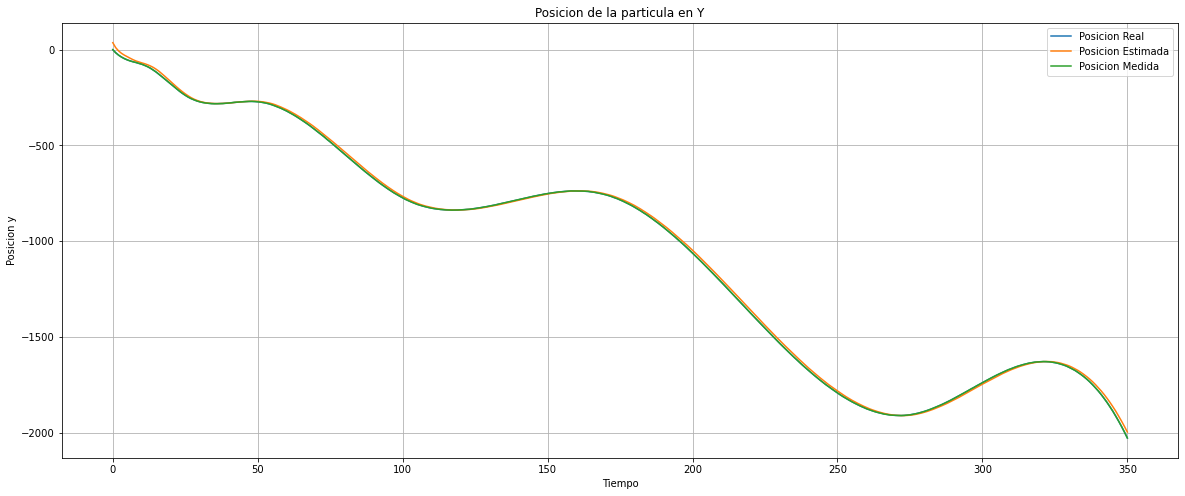

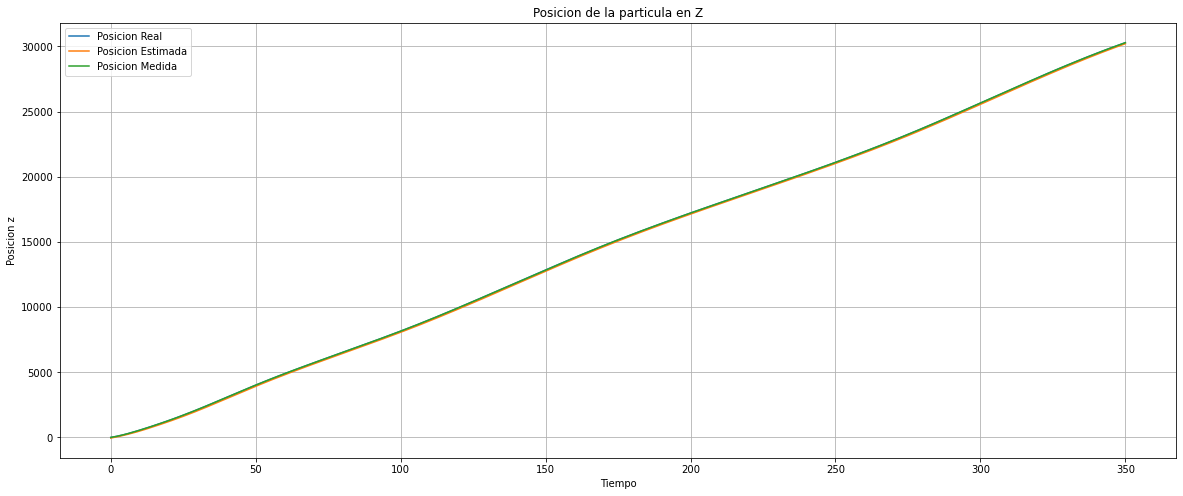

In [13]:
#   GRAFICAS DE POSICIONES REALES, MEDIDA Y ESTIMADAS POR EL FK

fig, px = plt.subplots(figsize=(20,8))
px.plot(posicion[:, 0], posicion[:, 1])
px.plot(posicion[:, 0], xn_n[:, 0])
px.plot(posicion[:, 0], yn[:, 0])
px.set_title('Posicion de la particula en X')
px.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
px.set_xlabel('Tiempo')
px.set_ylabel('Posicion x')
px.grid()

fig, py = plt.subplots(figsize=(20,8))
py.plot(posicion[:, 0], posicion[:, 2])
py.plot(posicion[:, 0], xn_n[:, 1])
py.plot(posicion[:, 0], yn[:, 1])
py.set_title('Posicion de la particula en Y')
py.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
py.set_xlabel('Tiempo')
py.set_ylabel('Posicion y')
py.grid()

fig, pz = plt.subplots(figsize=(20,8))
pz.plot(posicion[:, 0], posicion[:, 3])
pz.plot(posicion[:, 0], xn_n[:, 2])
pz.plot(posicion[:, 0], yn[:, 2])
pz.set_title('Posicion de la particula en Z')
pz.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
pz.set_xlabel('Tiempo')
pz.set_ylabel('Posicion z')
pz.grid()

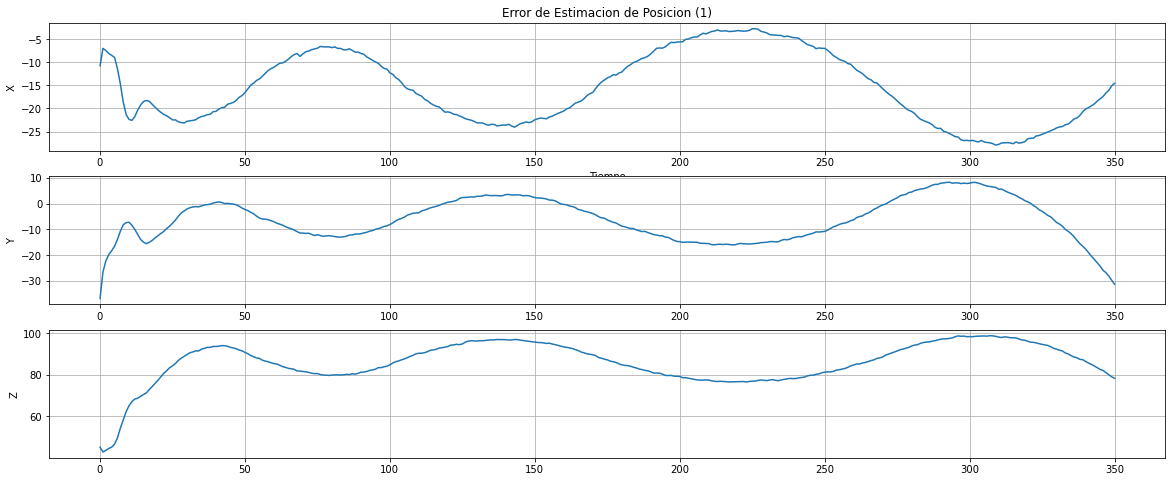

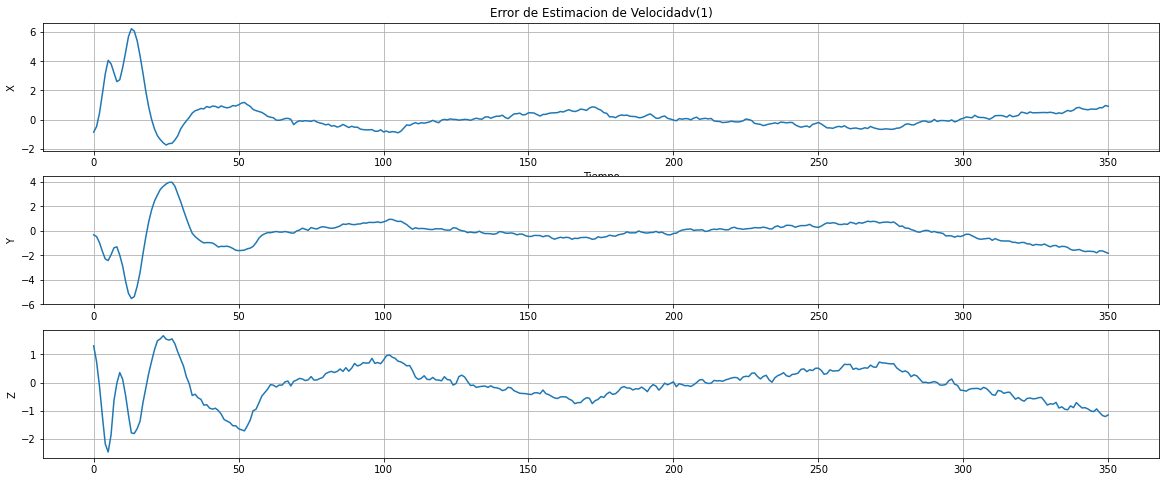

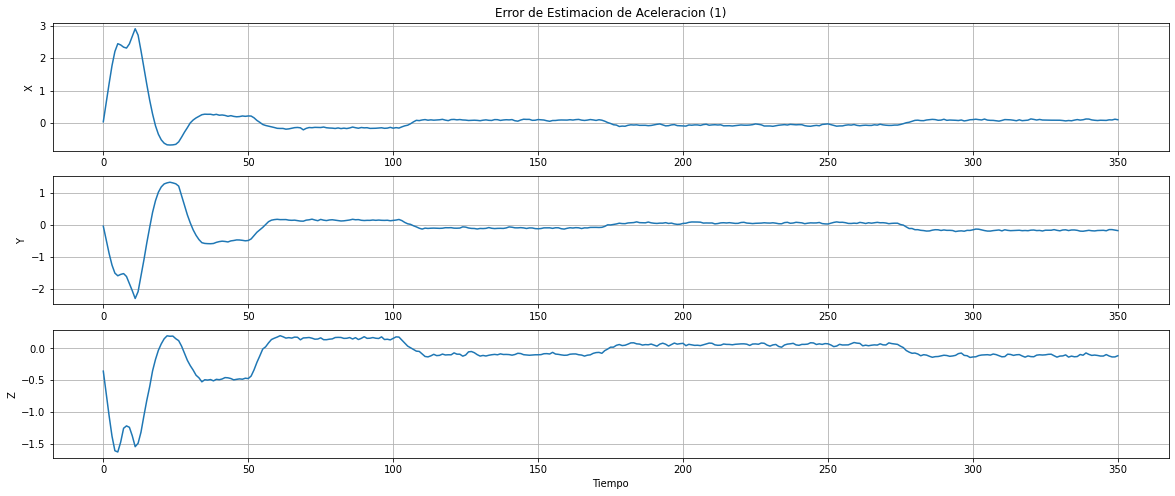

In [14]:
#   CALCULO DEL ERROR Xn - Xn_n

Err_1 = xn - xn_n

media_Error1 = Err_1.mean(0)
varianza_Error1 = Err_1.var(0)

fig, errorp_1 = plt.subplots(3,1,figsize=(20,8))
errorp_1[0].plot(posicion[:, 0], Err_1[:, 0])
errorp_1[1].plot(posicion[:, 0], Err_1[:, 1])
errorp_1[2].plot(posicion[:, 0], Err_1[:, 2])
errorp_1[0].set_title('Error de Estimacion de Posicion (1)')
errorp_1[0].set_xlabel('Tiempo')
errorp_1[0].set_ylabel('X')
errorp_1[1].set_ylabel('Y')
errorp_1[2].set_ylabel('Z')
errorp_1[0].grid()
errorp_1[1].grid()
errorp_1[2].grid()

fig, errorv_1 = plt.subplots(3,1,figsize=(20,8))
errorv_1[0].plot(posicion[:, 0], Err_1[:, 3])
errorv_1[1].plot(posicion[:, 0], Err_1[:, 4])
errorv_1[2].plot(posicion[:, 0], Err_1[:, 5])
errorv_1[0].set_title('Error de Estimacion de Velocidadv(1)')
errorv_1[0].set_xlabel('Tiempo')
errorv_1[0].set_ylabel('X')
errorv_1[1].set_ylabel('Y')
errorv_1[2].set_ylabel('Z')
errorv_1[0].grid()
errorv_1[1].grid()
errorv_1[2].grid()

fig, errora_1 = plt.subplots(3,1,figsize=(20,8))
errora_1[0].plot(posicion[:, 0], Err_1[:, 6])
errora_1[1].plot(posicion[:, 0], Err_1[:, 7])
errora_1[2].plot(posicion[:, 0], Err_1[:, 8])
errora_1[0].set_title('Error de Estimacion de Aceleracion (1)')
errora_1[2].set_xlabel('Tiempo')
errora_1[0].set_ylabel('X')
errora_1[1].set_ylabel('Y')
errora_1[2].set_ylabel('Z')
errora_1[0].grid()
errora_1[1].grid()
errora_1[2].grid()

Se mide la posición afectacda por ruido uniforme con desvio estandar 10m.

In [15]:
#   2 - VERIFICACION DEL FK CON RUIDO UNIFORME DE MEDICION

xn_n_2 = np.matrix(np.zeros((351,9)))

for i in range(N):
    #   Ruido de medicion con distribucion uniforme
    
    nu_uniforme = 10 * np.random.uniform(0, 1, (351, 3))
    yn_uniforme = np.dot(xn, C.T) + nu_uniforme
    
    #   Xn|n
    xn_n_2_i = np.matrix(np.zeros((351,9)))
    
    xn_n_2_i[0,:] = [10.7533, 36.6777, -45.1769,
                   1.1009, -17.0, 35.7418,
                   -5.7247, 3.4268, 5.2774]
    
    #   Pn|n
    pn_n_2 = np.matrix([[100, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 100, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 100, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0.01, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0.01, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0.01]])
    
    # Xn|n-1
    xn_n1_2 = np.matrix(np.zeros((351, 9)))
    
    for i in range(351):
        (xn_n1_2[i,:], pn_n1_2) = estimacionesXP(xn_n_2_i[i,:],
                                                 pn_n_2,
                                                 A,
                                                 Q)
        if i < 350:
            (xn_n_2_i[i+1,:], pn_n_2, Kn_2) = Filtro_Kalman(xn_n1_2[i,:], 
                                                          pn_n1_2,
                                                          yn_uniforme[i,:], 
                                                          C, 
                                                          R)

    xn_n_2 = xn_n_2 + xn_n_2_i

In [16]:
xn_n_2 = xn_n_2 / N

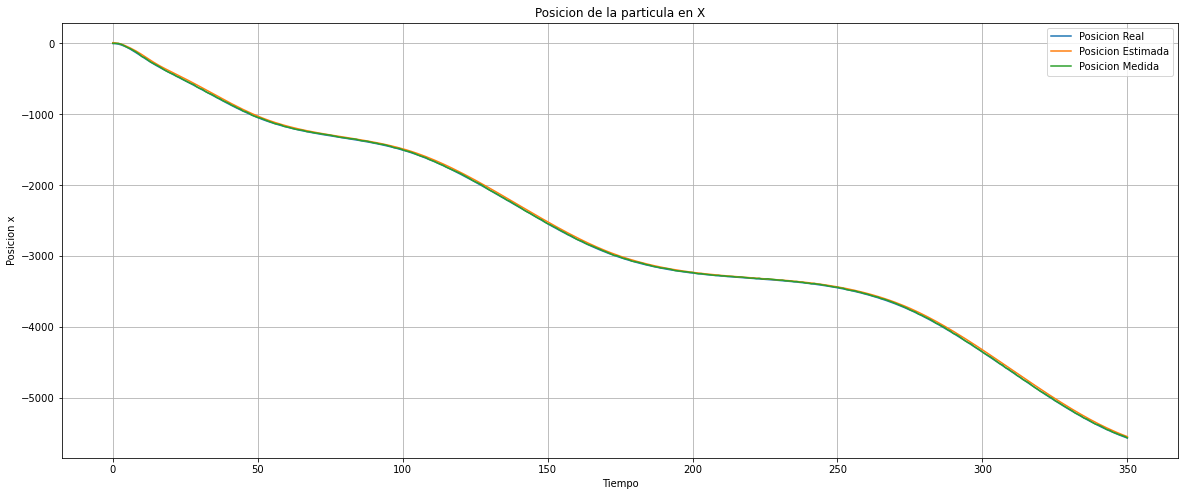

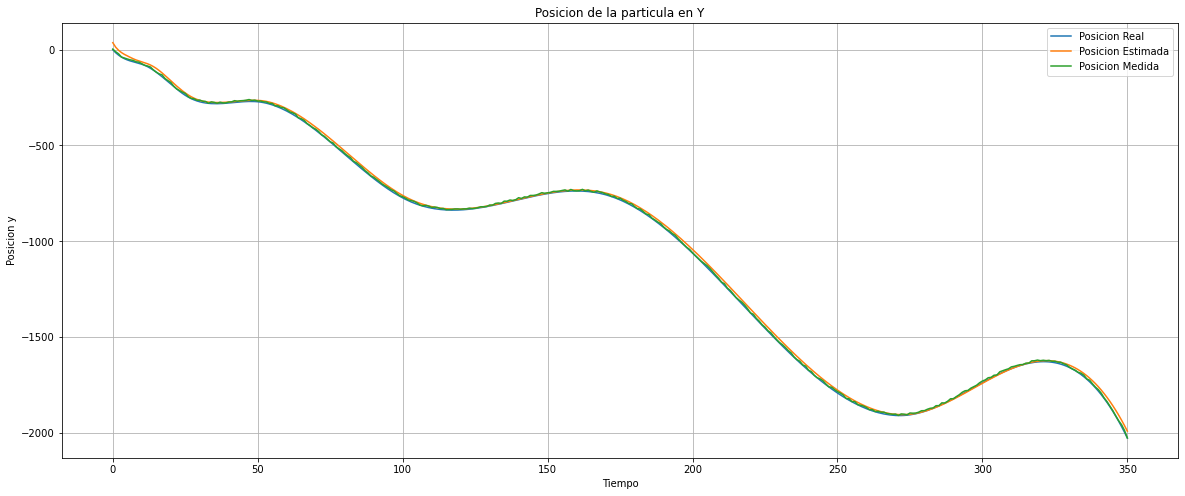

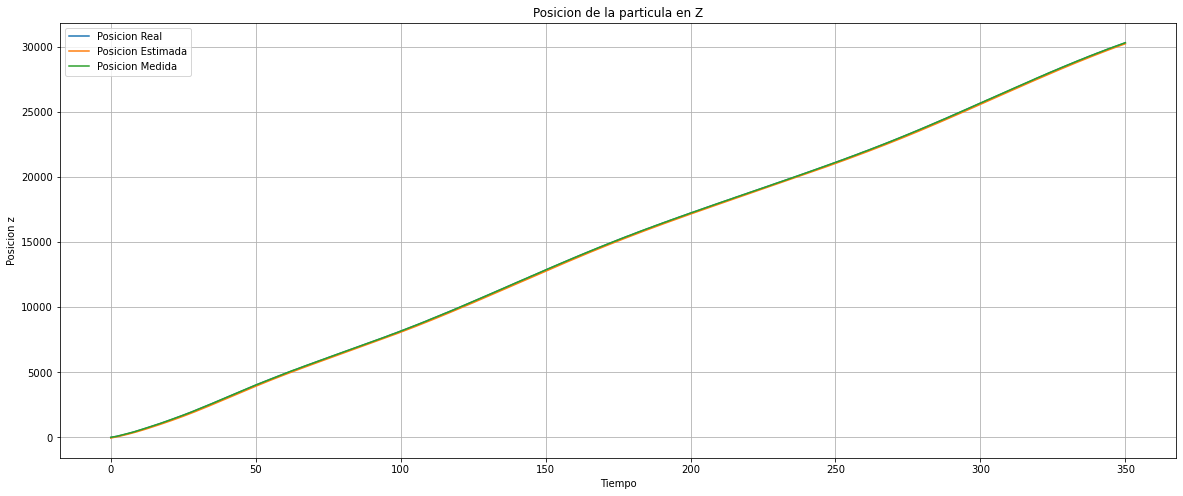

In [17]:
#   GRAFICAS DE POSICIONES REALES Y LAS ESTIMADAS POR EL FK

fig, px = plt.subplots(figsize=(20,8))
px.plot(posicion[:, 0], posicion[:, 1])
px.plot(posicion[:, 0], xn_n_2[:, 0])
px.plot(posicion[:, 0], yn_uniforme[:, 0] )
px.set_title('Posicion de la particula en X')
px.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
px.set_xlabel('Tiempo')
px.set_ylabel('Posicion x')
px.grid()

fig, py = plt.subplots(figsize=(20,8))
py.plot(posicion[:, 0], posicion[:, 2])
py.plot(posicion[:, 0], xn_n_2[:, 1])
py.plot(posicion[:, 0], yn_uniforme[:, 1] )
py.set_title('Posicion de la particula en Y')
py.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
py.set_xlabel('Tiempo')
py.set_ylabel('Posicion y')
py.grid()

fig, pz = plt.subplots(figsize=(20,8))
pz.plot(posicion[:, 0], posicion[:, 3])
pz.plot(posicion[:, 0], xn_n_2[:, 2])
pz.plot(posicion[:, 0], yn_uniforme[:, 2] )
pz.set_title('Posicion de la particula en Z')
pz.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
pz.set_xlabel('Tiempo')
pz.set_ylabel('Posicion z')
pz.grid()

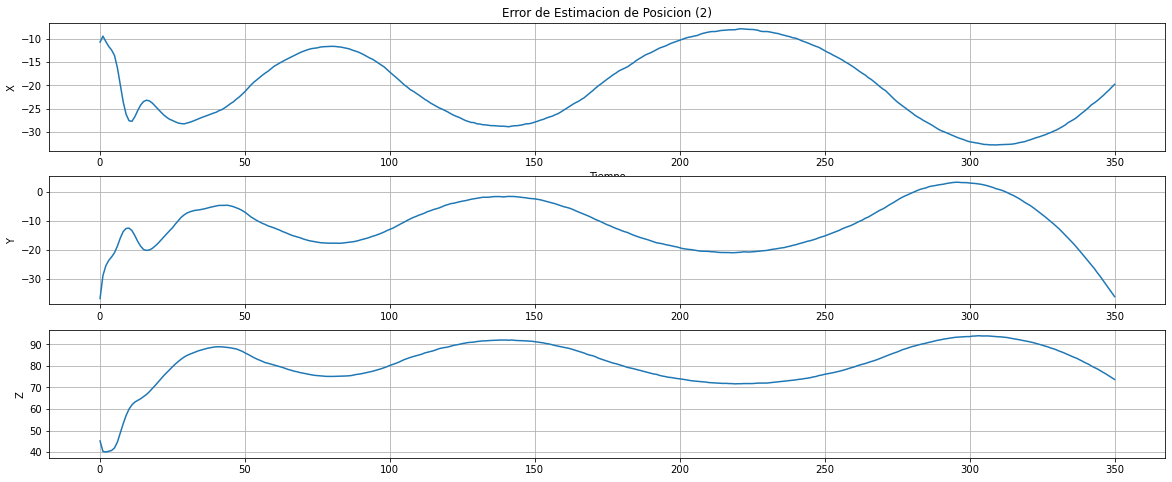

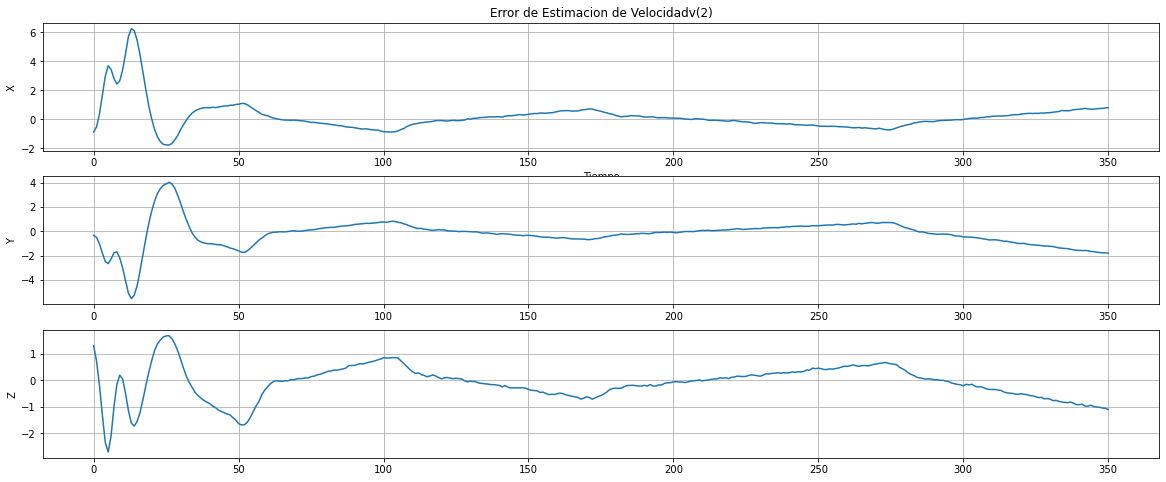

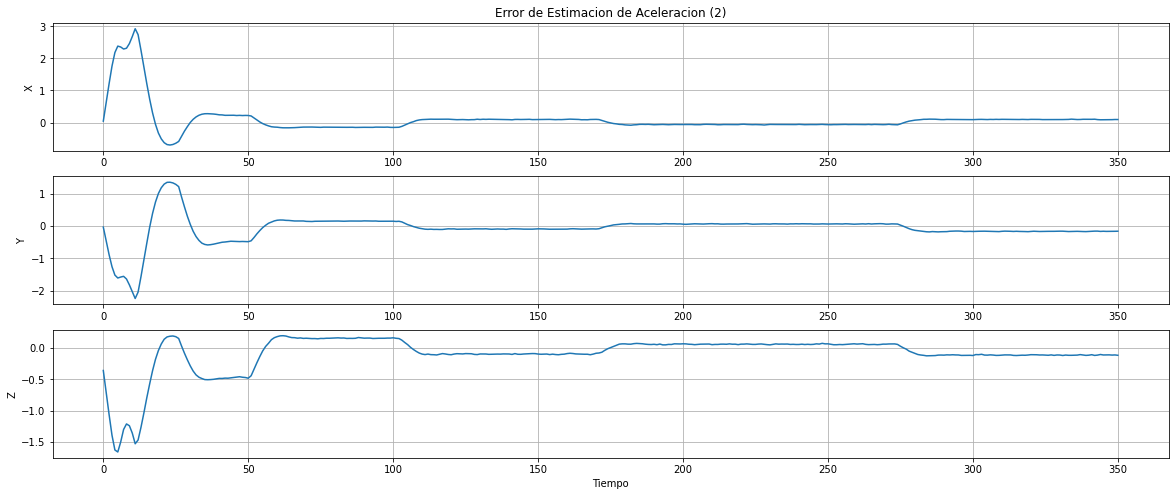

In [18]:
#   CALCULO DEL ERROR Xn - Xn_n_2

Err_2 = xn - xn_n_2
media_Error2 = Err_2.mean(0)


fig, errorp_2 = plt.subplots(3,1,figsize=(20,8))
errorp_2[0].plot(posicion[:, 0], Err_2[:, 0])
errorp_2[1].plot(posicion[:, 0], Err_2[:, 1])
errorp_2[2].plot(posicion[:, 0], Err_2[:, 2])
errorp_2[0].set_title('Error de Estimacion de Posicion (2)')
errorp_2[0].set_xlabel('Tiempo')
errorp_2[0].set_ylabel('X')
errorp_2[1].set_ylabel('Y')
errorp_2[2].set_ylabel('Z')
errorp_2[0].grid()
errorp_2[1].grid()
errorp_2[2].grid()

fig, errorv_2 = plt.subplots(3,1,figsize=(20,8))
errorv_2[0].plot(posicion[:, 0], Err_2[:, 3])
errorv_2[1].plot(posicion[:, 0], Err_2[:, 4])
errorv_2[2].plot(posicion[:, 0], Err_2[:, 5])
errorv_2[0].set_title('Error de Estimacion de Velocidadv(2)')
errorv_2[0].set_xlabel('Tiempo')
errorv_2[0].set_ylabel('X')
errorv_2[1].set_ylabel('Y')
errorv_2[2].set_ylabel('Z')
errorv_2[0].grid()
errorv_2[1].grid()
errorv_2[2].grid()

fig, errora_2 = plt.subplots(3,1,figsize=(20,8))
errora_2[0].plot(posicion[:, 0], Err_2[:, 6])
errora_2[1].plot(posicion[:, 0], Err_2[:, 7])
errora_2[2].plot(posicion[:, 0], Err_2[:, 8])
errora_2[0].set_title('Error de Estimacion de Aceleracion (2)')
errora_2[2].set_xlabel('Tiempo')
errora_2[0].set_ylabel('X')
errora_2[1].set_ylabel('Y')
errora_2[2].set_ylabel('Z')
errora_2[0].grid()
errora_2[1].grid()
errora_2[2].grid()

In [19]:
#   3 - VERIFICACION DEL FK CON RUIDO CON DISTRIBUCION GAUSSIANA DE MEDICION
#                     MEDICIONES DE POSICION Y VELOCIDAD
#

C_3 = np.matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0]])

xn_n_3 = np.matrix(np.zeros((351, 9)))

for i in range(N):
    
    
    #   RUIDO DE MEDICION
    
    #   Se utiliza un ruido con distribucion gaussiana
    nu_gauss_2 = np.zeros((posicion.shape[0], (posicion.shape[1] - 1) * 2))
    
    for col in range(posicion.shape[1]-1):
        nu_gauss_2[:, col] = np.random.normal(0, 10, posicion.shape[0])
    
    for col in range(3,(posicion.shape[1] - 1) * 2):
        nu_gauss_2[:, col] = np.random.normal(0, 0.2, posicion.shape[0])
    
    R_3 = np.matrix([[100, 0, 0, 0, 0, 0],
                     [0, 100, 0, 0, 0, 0],
                     [0, 0, 100, 0, 0, 0],
                     [0, 0, 0, 0.04, 0, 0],
                     [0, 0, 0, 0, 0.04, 0],
                     [0, 0, 0, 0, 0, 0.04]])
    
    #   Defino Yn como la suma del las variables medidas mas un ruido de medicion
    
    yn_3 = np.dot(xn,C_3.T) + nu_gauss_2
    
    #   Xn|n
    xn_n_3_i = np.matrix(np.zeros((351, 9)))
    
    xn_n_3_i[0,:] = [10.7533, 36.6777, -45.1769,
                     1.1009, -17.0, 35.7418,
                     -5.7247, 3.4268, 5.2774]
    
    #   Pn|n
    pn_n_3 = np.matrix([[100, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 100, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 100, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0.01, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0.01, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0.01]])
    
    # Xn|n-1
    xn_n1_3 = np.matrix(np.zeros((351,9)))
    
    for i in range(351):
        (xn_n1_3[i,:], pn_n1_3) = estimacionesXP(xn_n_3_i[i,:],
                                                 pn_n_3,
                                                 A,
                                                 Q)
        if i < 350:
            (xn_n_3_i[i+1,:], pn_n_3, Kn_3) = Filtro_Kalman(xn_n1_3[i,:], 
                                                          pn_n1_3,
                                                          yn_3[i,:], 
                                                          C_3, 
                                                          R_3)
        
    xn_n_3 = xn_n_3 + xn_n_3_i

In [20]:
xn_n_3 = xn_n_3 / N

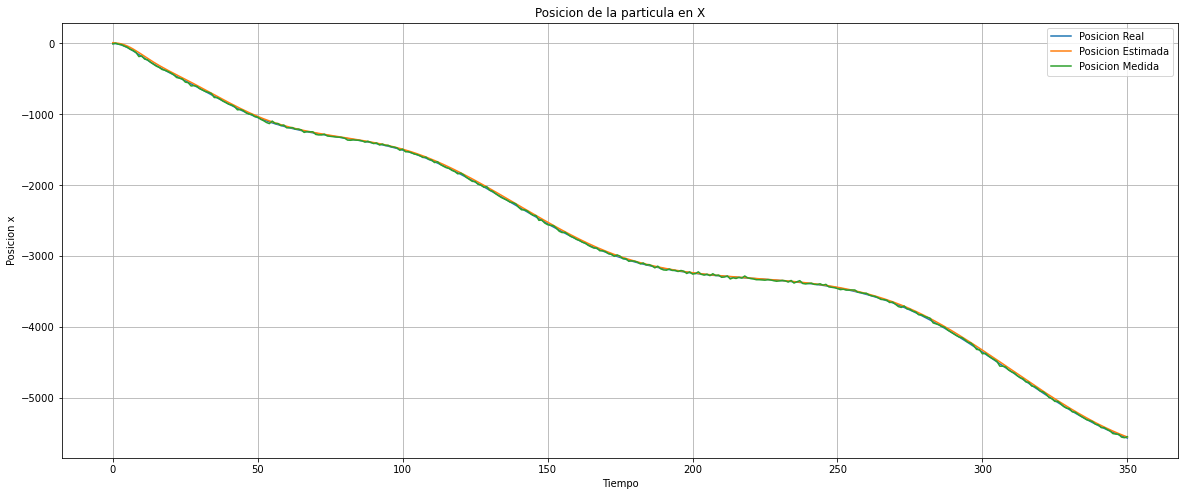

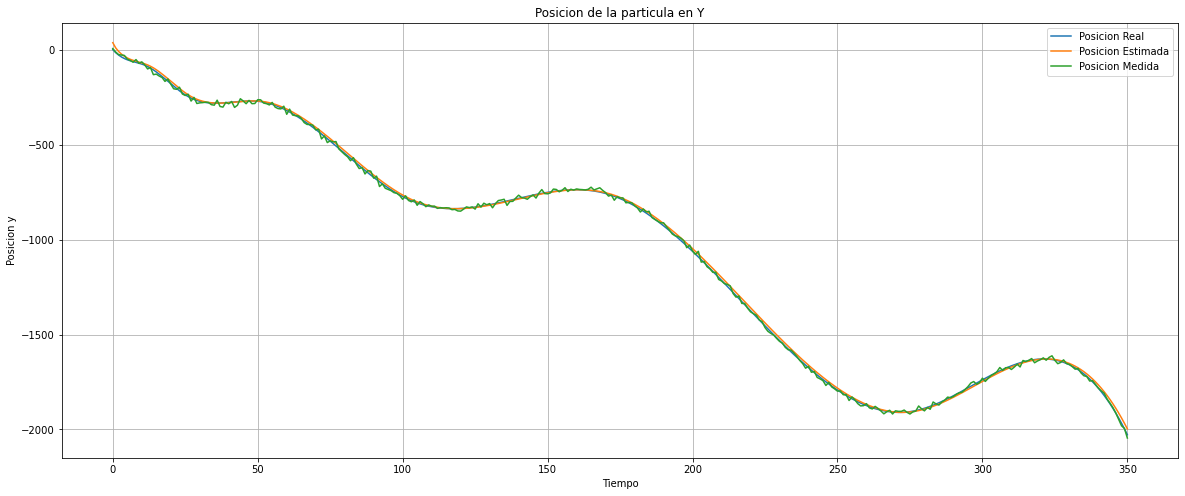

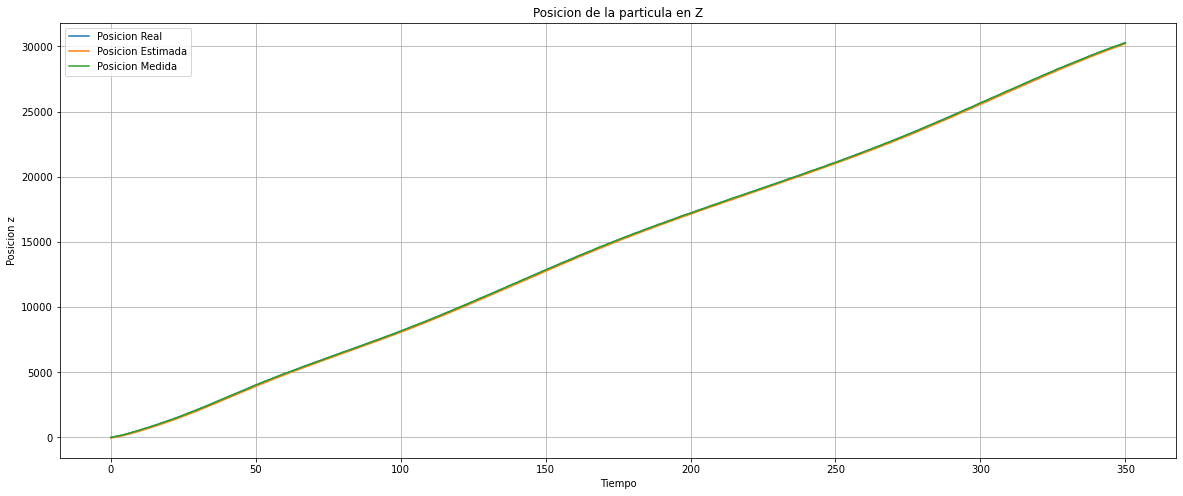

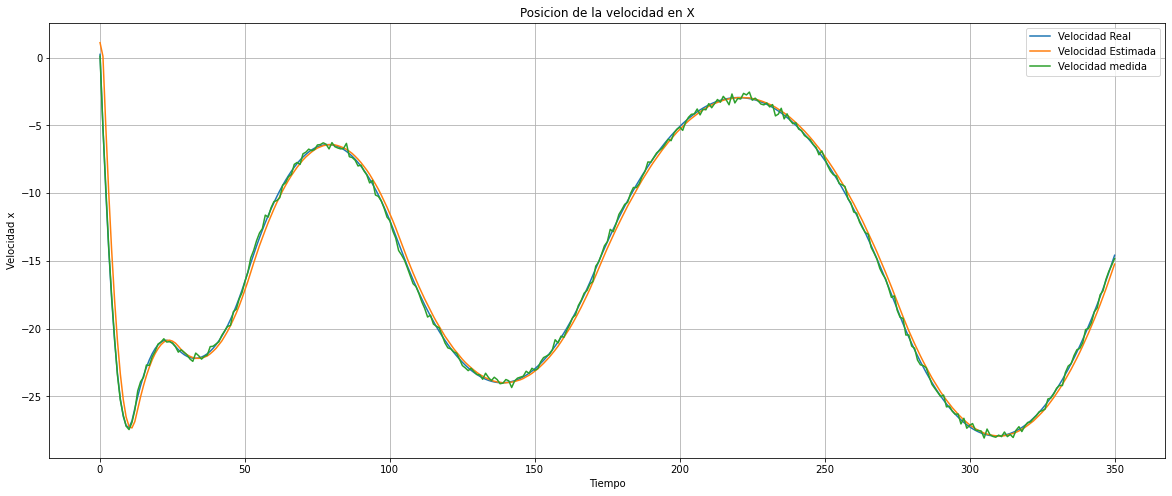

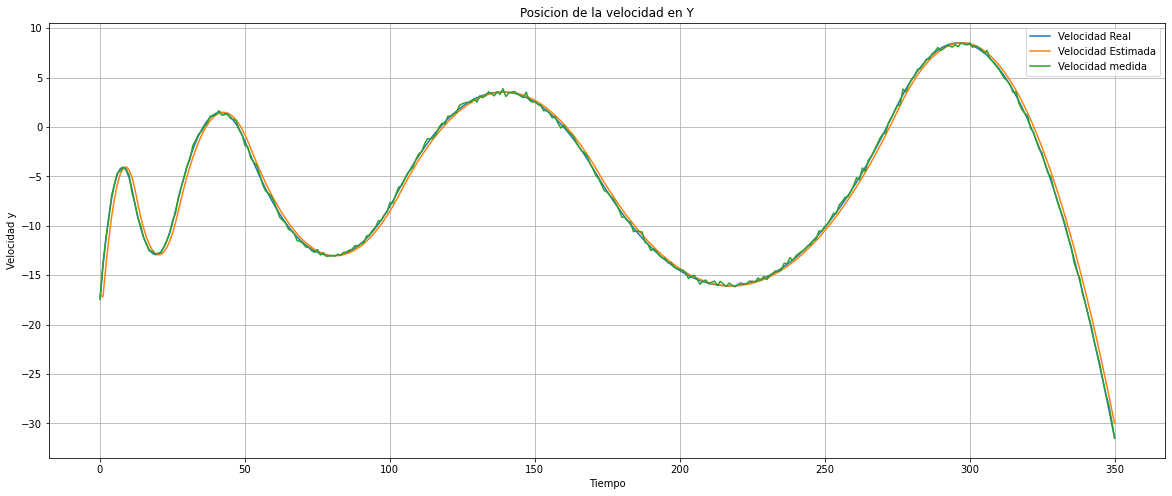

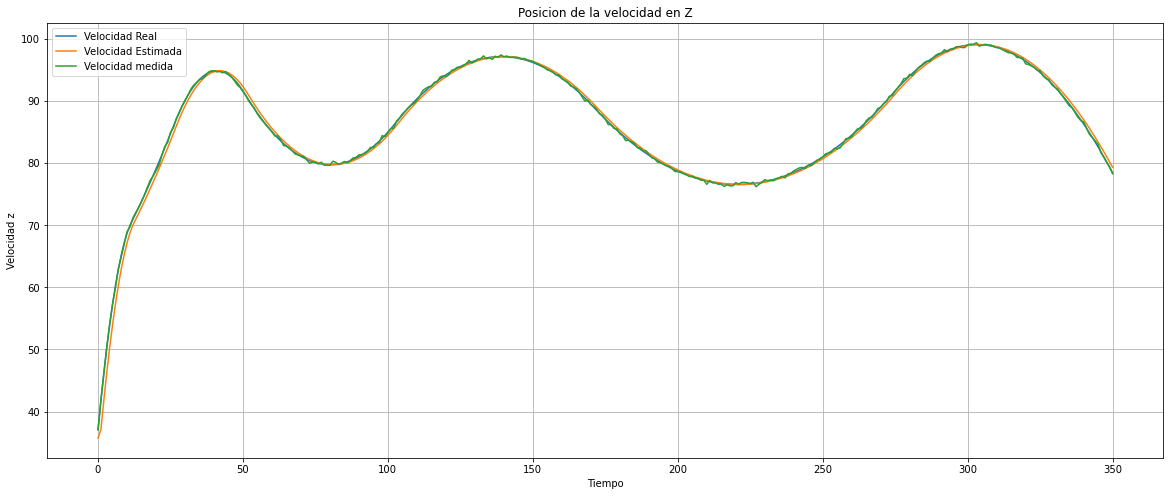

In [21]:
fig, px = plt.subplots(figsize=(20,8))
px.plot(posicion[:, 0], posicion[:, 1])
px.plot(posicion[:, 0], xn_n_3[:, 0])
px.plot(posicion[:, 0], yn_3[:, 0])
px.set_title('Posicion de la particula en X')
px.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
px.set_xlabel('Tiempo')
px.set_ylabel('Posicion x')
px.grid()

fig, py = plt.subplots(figsize=(20,8))
py.plot(posicion[:, 0], posicion[:, 2])
py.plot(posicion[:, 0], xn_n_3[:, 1])
py.plot(posicion[:, 0], yn_3[:, 1])
py.set_title('Posicion de la particula en Y')
py.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
py.set_xlabel('Tiempo')
py.set_ylabel('Posicion y')
py.grid()

fig, pz = plt.subplots(figsize=(20,8))
pz.plot(posicion[:, 0], posicion[:, 3])
pz.plot(posicion[:, 0], xn_n_3[:, 2])
pz.plot(posicion[:, 0], yn_3[:, 2])
pz.set_title('Posicion de la particula en Z')
pz.legend(('Posicion Real', 
           'Posicion Estimada', 
           'Posicion Medida'))
pz.set_xlabel('Tiempo')
pz.set_ylabel('Posicion z')
pz.grid()

fig, vx = plt.subplots(figsize=(20,8))
vx.plot(velocidad[:, 0], velocidad[:, 1])
vx.plot(velocidad[:, 0], xn_n_3[:, 3])
vx.plot(velocidad[:, 0], yn_3[:, 3])
vx.set_title('Posicion de la velocidad en X')
vx.legend(('Velocidad Real', 
           'Velocidad Estimada', 
           'Velocidad medida'))
vx.set_xlabel('Tiempo')
vx.set_ylabel('Velocidad x')
vx.grid()

fig, vy = plt.subplots(figsize=(20,8))
vy.plot(velocidad[:, 0], velocidad[:, 2])
vy.plot(velocidad[:, 0], xn_n_3[:, 4])
vy.plot(velocidad[:, 0], yn_3[:, 4])
vy.set_title('Posicion de la velocidad en Y')
vy.legend(('Velocidad Real', 
           'Velocidad Estimada', 
           'Velocidad medida'))
vy.set_xlabel('Tiempo')
vy.set_ylabel('Velocidad y')
vy.grid()

fig, vz = plt.subplots(figsize=(20,8))
vz.plot(velocidad[:, 0], velocidad[:, 3])
vz.plot(velocidad[:, 0], xn_n_3[:, 5])
vz.plot(velocidad[:, 0], yn_3[:, 5])
vz.set_title('Posicion de la velocidad en Z')
vz.legend(('Velocidad Real', 
           'Velocidad Estimada',
           'Velocidad medida'))
vz.set_xlabel('Tiempo')
vz.set_ylabel('Velocidad z')
vz.grid()

In [22]:
#   CALCULO DEL ERROR Xn - Xn_n_2

Err_3 = xn - xn_n_3
media_Error3 = Err_3.mean(0)

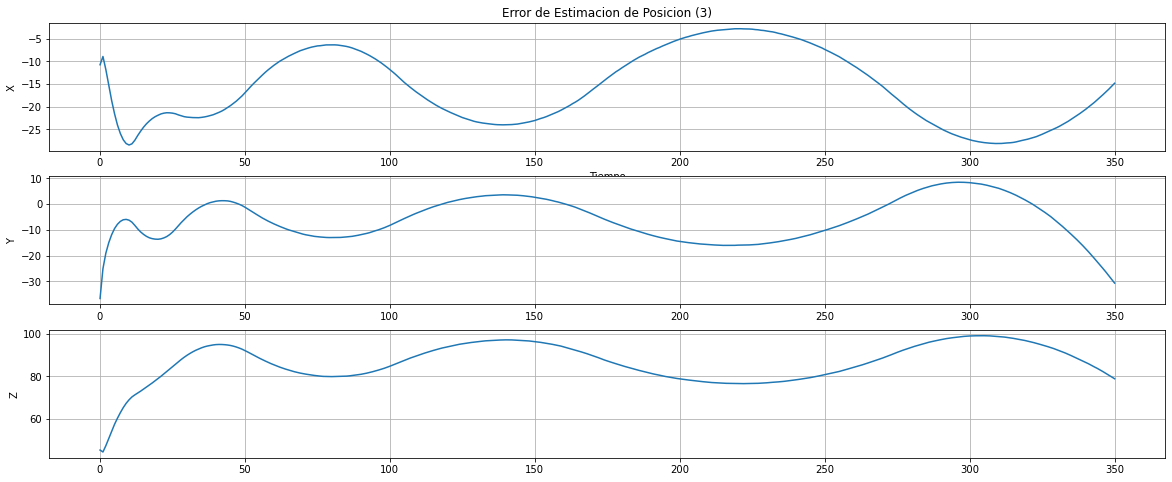

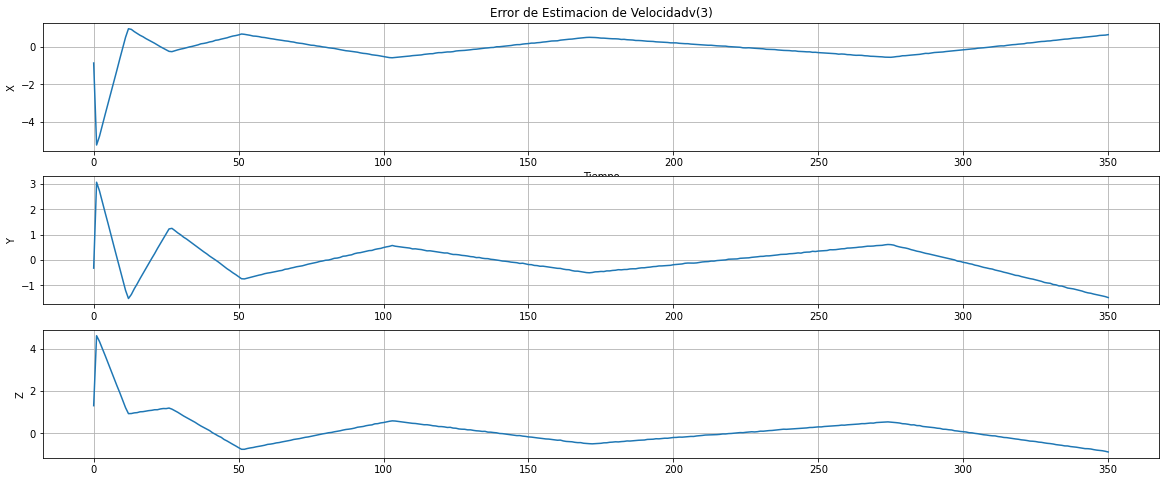

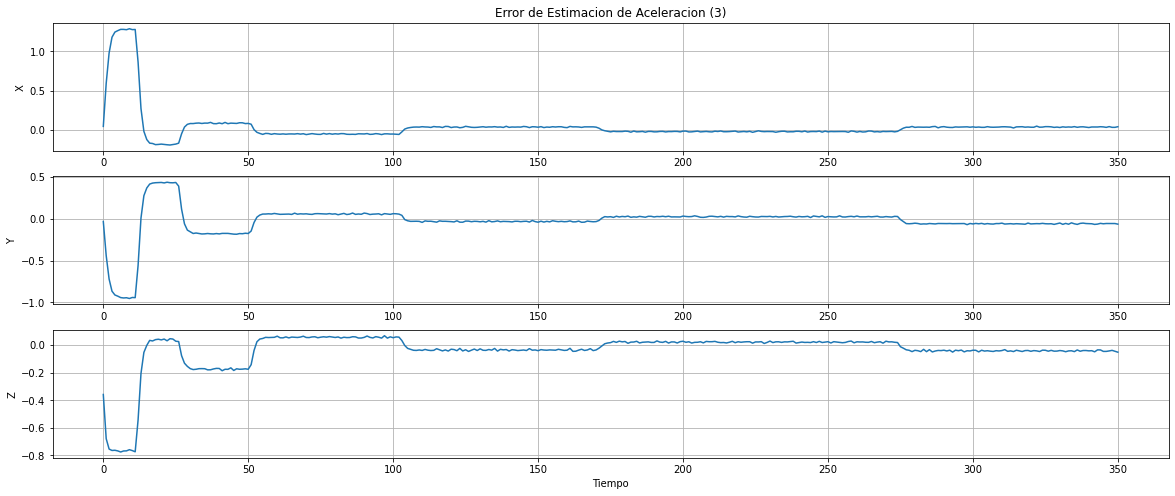

In [23]:
fig, errorp_3 = plt.subplots(3,1,figsize=(20,8))
errorp_3[0].plot(posicion[:, 0], Err_3[:, 0])
errorp_3[1].plot(posicion[:, 0], Err_3[:, 1])
errorp_3[2].plot(posicion[:, 0], Err_3[:, 2])
errorp_3[0].set_title('Error de Estimacion de Posicion (3)')
errorp_3[0].set_xlabel('Tiempo')
errorp_3[0].set_ylabel('X')
errorp_3[1].set_ylabel('Y')
errorp_3[2].set_ylabel('Z')
errorp_3[0].grid()
errorp_3[1].grid()
errorp_3[2].grid()

fig, errorv_3 = plt.subplots(3,1,figsize=(20,8))
errorv_3[0].plot(posicion[:, 0], Err_3[:, 3])
errorv_3[1].plot(posicion[:, 0], Err_3[:, 4])
errorv_3[2].plot(posicion[:, 0], Err_3[:, 5])
errorv_3[0].set_title('Error de Estimacion de Velocidadv(3)')
errorv_3[0].set_xlabel('Tiempo')
errorv_3[0].set_ylabel('X')
errorv_3[1].set_ylabel('Y')
errorv_3[2].set_ylabel('Z')
errorv_3[0].grid()
errorv_3[1].grid()
errorv_3[2].grid()

fig, errora_3 = plt.subplots(3,1,figsize=(20,8))
errora_3[0].plot(posicion[:, 0], Err_3[:, 6])
errora_3[1].plot(posicion[:, 0], Err_3[:, 7])
errora_3[2].plot(posicion[:, 0], Err_3[:, 8])
errora_3[0].set_title('Error de Estimacion de Aceleracion (3)')
errora_3[2].set_xlabel('Tiempo')
errora_3[0].set_ylabel('X')
errora_3[1].set_ylabel('Y')
errora_3[2].set_ylabel('Z')
errora_3[0].grid()
errora_3[1].grid()
errora_3[2].grid()